In [1]:
# import pandas as pd
# import numpy as np

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('data.csv')

In [7]:
df.head(4)
#0 - human 
#1 - ai

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1


In [8]:
# df.rename(columns = {'Data':'text'}, inplace = True) 
df.rename(columns = {'generated':'class'}, inplace = True) 

In [9]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check for class balance
print("\nClass distribution:")
print(df['class'].value_counts())

# Basic preprocessing: removing missing values
df.dropna(inplace=True)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.2, random_state=42)

# Output the size of the splits
print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Missing values in each column:
text     0
class    0
dtype: int64

Class distribution:
class
0    17508
1    11637
Name: count, dtype: int64

Training set size: 23316
Testing set size: 5829


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000  e
MAX_SEQUENCE_LENGTH = 250 

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Shape of training data:", X_train_padded.shape)
print("Shape of testing data:", X_test_padded.shape)

Shape of training data: (23316, 250)
Shape of testing data: (5829, 250)


In [14]:
import numpy as np

# Function to calculate ratio of unique words
def ratio_of_unique_words(text):
    words = text.split()
    unique_words = set(words)  # Use a set to count unique words
    return len(unique_words) / len(words) if words else 0

# Calculate simple linguistic features
X_train_lengths = np.array([len(text.split()) for text in X_train])  # Text length
X_train_avg_word_length = np.array([np.mean([len(word) for word in text.split()]) for text in X_train])  # Average word length
X_train_unique_word_ratio = np.array([ratio_of_unique_words(text) for text in X_train]) # The ratio of unique words

X_test_lengths = np.array([len(text.split()) for text in X_test])
X_test_avg_word_length = np.array([np.mean([len(word) for word in text.split()]) for text in X_test])
X_test_unique_word_ratio = np.array([ratio_of_unique_words(text) for text in X_test]) 

# Stack features together for MLP input
X_train_features = np.vstack((X_train_lengths, X_train_avg_word_length, X_train_unique_word_ratio)).T
X_test_features = np.vstack((X_test_lengths, X_test_avg_word_length, X_test_unique_word_ratio)).T


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Model parameters
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)  # Vocabulary size
EMBEDDING_DIM = 100  # Size of the embedding vectors 
FILTERS = 128  # Number of filters for the Conv layer
KERNEL_SIZE = 5  # Size of the kernel for the Conv layer
DENSE_UNITS = 10  # Number of units in the Dense layer

2024-03-24 22:20:50.403343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 22:20:50.403726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 22:20:50.405129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1065429 (4.06 MB)
Trainable params: 1065429 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten

# Model configuration parameters
MAX_SEQUENCE_LENGTH = 250  
VOCAB_SIZE = 10000  
EMBEDDING_DIM = 256 
FILTERS = 128  
KERNEL_SIZE = 5  
DENSE_UNITS = 18  
DROPOUT_RATE = 0.3  # Dropout rate for regularization

# CNN part for text
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
text_features = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
text_features = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(text_features)
text_features = GlobalMaxPooling1D()(text_features)
text_features = Dropout(DROPOUT_RATE)(text_features)  

# MLP part for linguistic features
linguistic_input = Input(shape=(3,))  
linguistic_features = Dense(DENSE_UNITS, activation='relu')(linguistic_input)
linguistic_features = Dropout(DROPOUT_RATE)(linguistic_features)  

# Concatenate the outputs of the two models
combined_features = concatenate([text_features, linguistic_features])

# Final classification layer
classification_output = Dense(1, activation='sigmoid')(combined_features)

model = Model(inputs=[text_input, linguistic_input], outputs=classification_output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 250, 256)             2560000   ['input_7[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 246, 128)             163968    ['embedding_4[0][0]']         
                                                                                                  
 input_8 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                            

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit([X_train_padded, X_train_features], y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=([X_test_padded, X_test_features], y_test),
                    callbacks=[early_stopping])

# Note: The batch_size and epochs are set to small numbers for demonstration.


Epoch 1/10
729/729 [==============================] - 20s 26ms/step - loss: 1.5199 - accuracy: 0.8733 - val_loss: 0.0469 - val_accuracy: 0.9858
Epoch 2/10
729/729 [==============================] - 6s 8ms/step - loss: 0.0425 - accuracy: 0.9860 - val_loss: 0.0268 - val_accuracy: 0.9900
Epoch 3/10
729/729 [==============================] - 4s 6ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0220 - val_accuracy: 0.9926
Epoch 4/10
729/729 [==============================] - 3s 4ms/step - loss: 0.0096 - accuracy: 0.9963 - val_loss: 0.0228 - val_accuracy: 0.9938


183/183 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9926
Test Accuracy: 99.26%


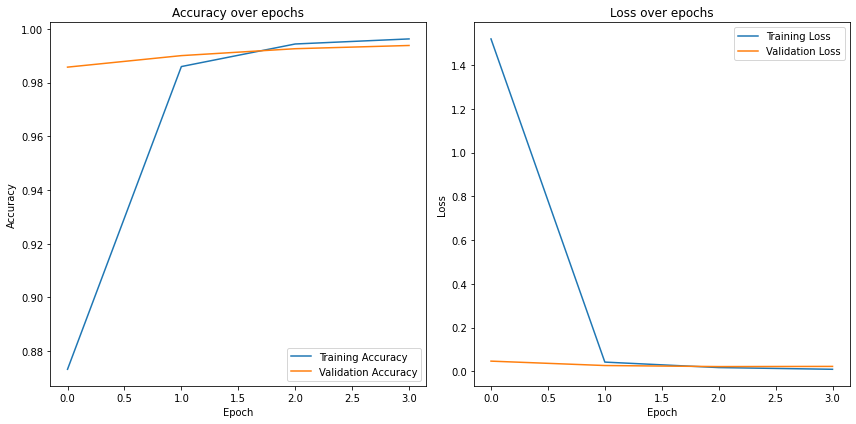

In [44]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_features], y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plotting training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)



In [45]:
def predict_text(text, tokenizer, model, MAX_SEQUENCE_LENGTH):
    # Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    
    # Calculate the linguistic features for the input text
    text_length = len(text.split())
    avg_word_length = np.mean([len(word) for word in text.split()]) if text.split() else 0
    unique_word_ratio = ratio_of_unique_words(text)
    
    # Update the features array to include the new feature
    features = np.array([[text_length, avg_word_length, unique_word_ratio]])
    
    # Make a prediction
    prediction = model.predict([padded_seq, features])
    
    # Interpret the prediction
    prediction_label = "AI Generated Essay" if prediction >= 0.5 else "Human Written Essay"
    return prediction_label

# Example usage
user_input = input("Please enter a sentence to classify: ")
prediction_label = predict_text(user_input, tokenizer, model, MAX_SEQUENCE_LENGTH)
print("The text is predicted to be a", prediction_label)


Please enter a sentence to classify: Indiana University–Purdue University Indianapolis, commonly referred to as IUPUI,[a] is a public research university in Indianapolis, Indiana, United States. It is a collaboration between Indiana University and Purdue University that offers undergraduate, graduate, and professional degrees from both universities. Administered primarily through Indiana University as a core campus and secondarily through Purdue University as a regional campus, it is Indiana's primary urban research and academic health sciences institution. IUPUI is located in downtown Indianapolis along the White River and Fall Creek.  Among more than 550 degree programs, the urban university hosts the primary campuses for both the Indiana University School of Medicine, with more than 2,000 students, and the Indiana University School of Dentistry, the only dental school in the state. Also, the Indiana University Robert H. McKinney School of Law is one of the two Indiana University law

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


In [47]:
def predict_text(text, tokenizer, model, MAX_SEQUENCE_LENGTH):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    
    text_length = len(text.split())
    avg_word_length = np.mean([len(word) for word in text.split()]) if text.split() else 0
    unique_word_ratio = ratio_of_unique_words(text)
    
    features = np.array([[text_length, avg_word_length, unique_word_ratio]])
    
    prediction = model.predict([padded_seq, features])
    return 1 if prediction >= 0.5 else 0


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
new_dataset = pd.read_csv('reddit_filtered_dataset.csv')


In [49]:
predicted_labels = []
actual_labels = new_dataset['class'].tolist()

for text in new_dataset['text']:
    predicted_label = predict_text(text, tokenizer, model, MAX_SEQUENCE_LENGTH)
    predicted_labels.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy on the new dataset: {accuracy*100:.2f}%")


1/1 [==============================] - 0s 10ms/step
Accuracy on the new dataset: 54.57%
